In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns; sns.set_theme()


# %matplotlib inline
plt.style.use('ggplot')

In [2]:
# fetching data
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path, header = None, names = column_names)
    return data

# feature normalization
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [3]:
dataset = read_data('WISDM_at_v2.0_raw.csv')
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])
print(dataset["activity"].unique())

['Walking' 'LyingDown' 'Standing' 'Sitting' 'Jogging' 'Stairs']


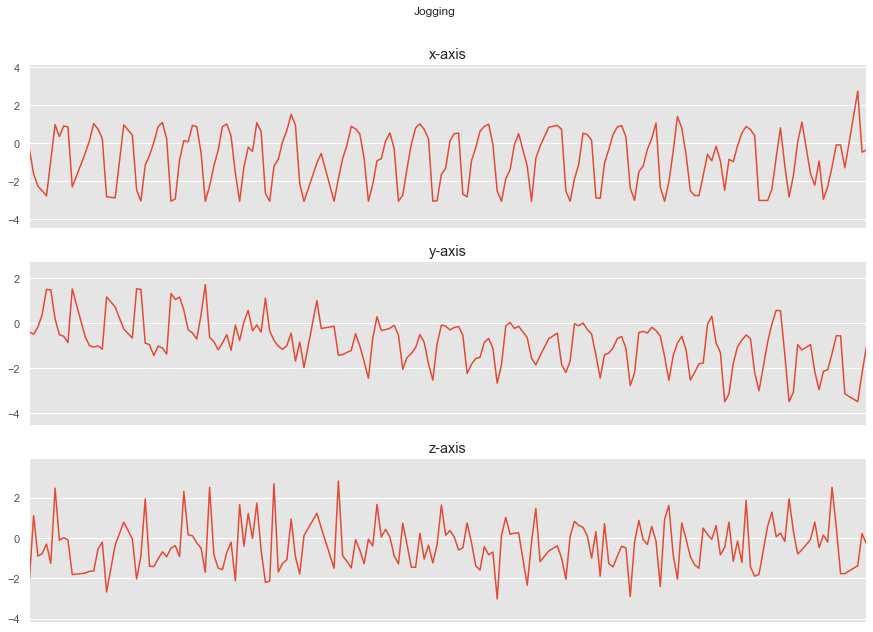

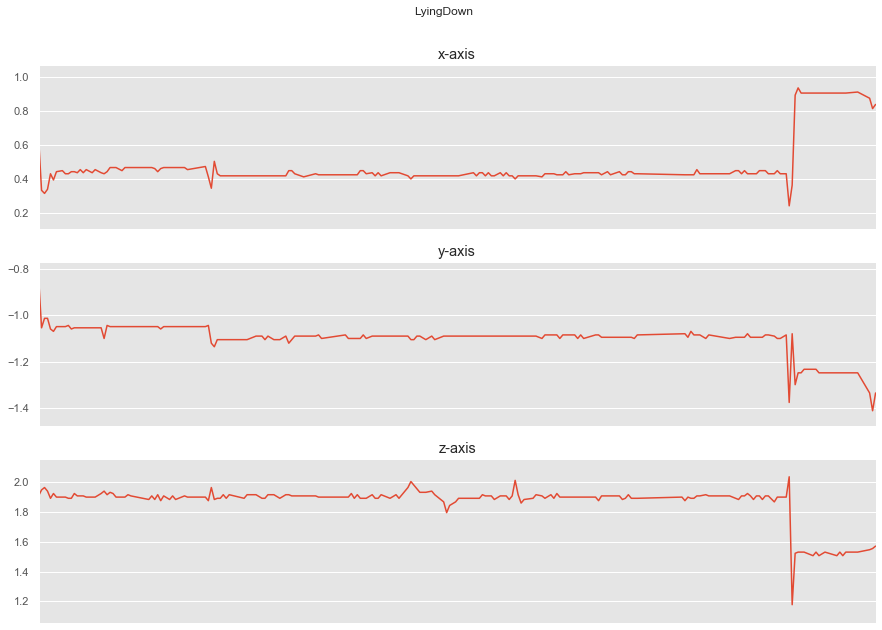

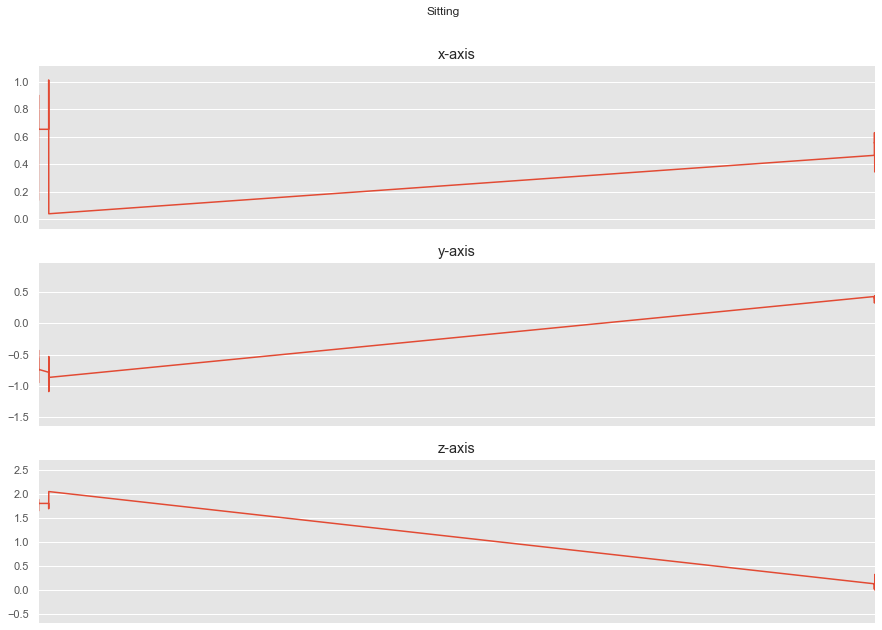

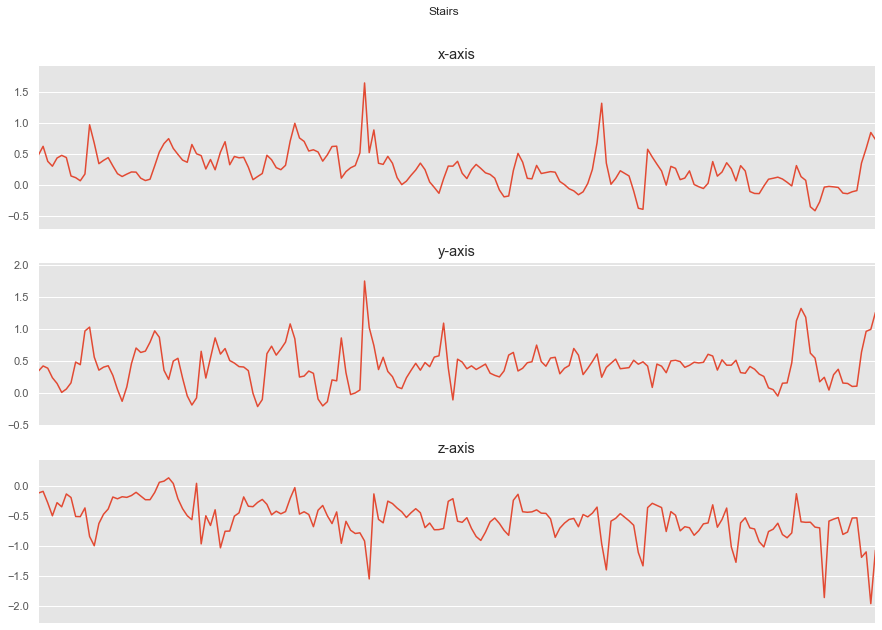

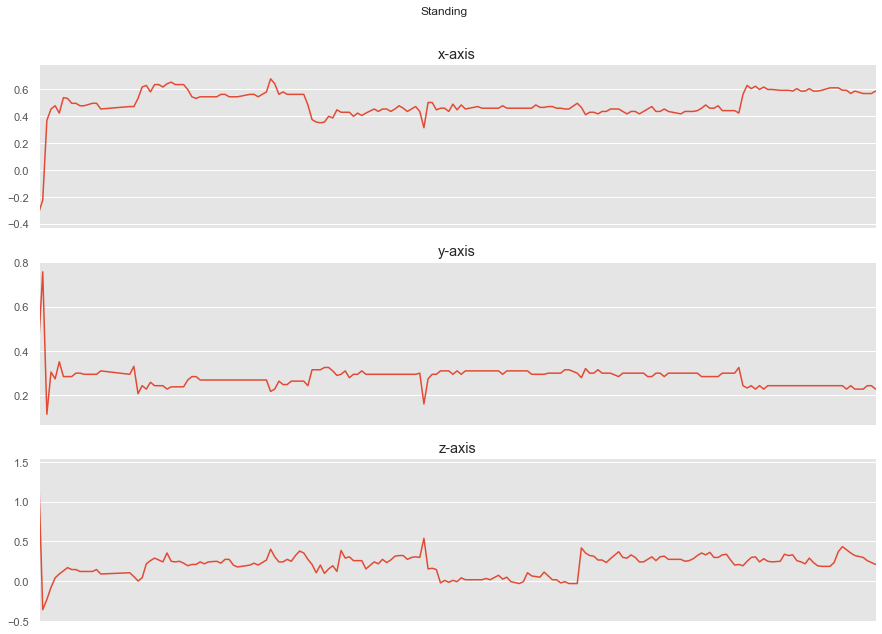

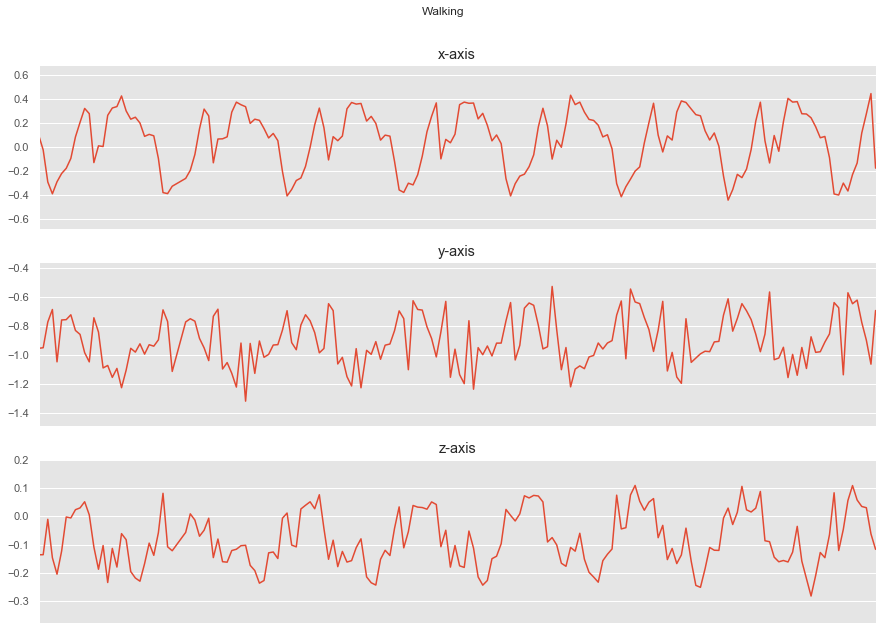

In [4]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)


In [5]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [8]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [9]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [10]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [11]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
prediction = tf.argmax(y_,1); 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))
    # print (y_)
    predicted_label = session.run(prediction , feed_dict={X: test_x, Y: test_y})
    print(predicted_label);

Epoch:  0  Training Loss:  12.709385  Training Accuracy:  0.7619501
Epoch:  1  Training Loss:  11.013744  Training Accuracy:  0.8
Epoch:  2  Training Loss:  10.348455  Training Accuracy:  0.8149822
Epoch:  3  Training Loss:  9.94318  Training Accuracy:  0.8321046
Epoch:  4  Training Loss:  9.683562  Training Accuracy:  0.8411415
Epoch:  5  Training Loss:  9.424278  Training Accuracy:  0.8480381
Epoch:  6  Training Loss:  9.193411  Training Accuracy:  0.84185493
Epoch:  7  Training Loss:  8.960559  Training Accuracy:  0.8454221
Testing Accuracy: 0.83836085
[4 4 4 ... 2 2 2]


In [13]:
# predicting label and confusion matrix
# print(predicted_label.shape, test_y.shape);
test_y_label = np.argmax(test_y, axis=1);
# print(test_y_label);
res = tf.math.confusion_matrix(predicted_label,test_y_label,num_classes=6);
print(res);
# confusion = res.numpy();
# print(confusion);
sess = tf.Session()
with sess.as_default():
    res = res.eval();


sum_of_rows = res.sum(axis=1)
res_normalize = res / sum_of_rows[:, np.newaxis];
res_normalize = np.nan_to_num(res_normalize)
res_normalize = np.around(res_normalize,decimals=3)
print(res_normalize);

Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(6, 6), dtype=int32)
[[0.933 0.    0.    0.    0.    0.067]
 [0.    0.818 0.152 0.    0.03  0.   ]
 [0.183 0.029 0.572 0.    0.119 0.097]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.175 0.    0.59  0.235]
 [0.034 0.002 0.005 0.023 0.009 0.927]]


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


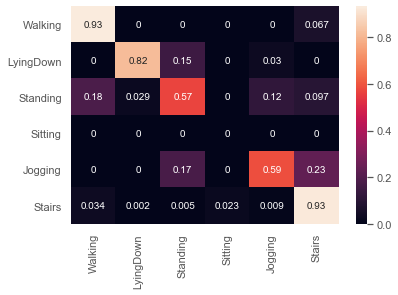

In [34]:
activity = ['Walking', 'LyingDown', 'Standing', 'Sitting', 'Jogging', 'Stairs'];



# fig, ax = plt.subplots()
# im = ax.imshow(res_normalize)

# # We want to show all ticks...
# ax.set_xticks(np.arange(len(activity)))
# ax.set_yticks(np.arange(len(activity)))
# # ... and label them with the respective list entries
# ax.set_xticklabels(activity)
# ax.set_yticklabels(activity)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(activity)):
#     for j in range(len(activity)):
#         text = ax.text(j, i, res_normalize[i, j],
#                        ha="center", va="center", color="w")

# ax.set_title("Confusion Matrix for Human Activity Recognition")
# # fig.tight_layout()
# plt.show()
x_ticks = [i*1 for i in range(0,6)];
ax = sns.heatmap(res_normalize,annot = True, xticklabels = activity, yticklabels = activity)
# plt.xticks(x_ticks,labels=activity)
# plt.yticks(x_ticks,labels=activity)
# plt.title('Confusion matrix')
# plt.xlabel('Actual label')
# plt.ylabel('Predicted label');
ax.set_ylim(len(activity),0);
